# Rohlik Orders Forecasting Challenge. 

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Ignore warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
# Load the data
train_df = pd.read_csv('./rohlik-orders-forecasting-challenge/train.csv')
scoring_df = pd.read_csv('./rohlik-orders-forecasting-challenge/test.csv')

# Save the test IDs
test_id = scoring_df['id']

In [3]:
basic_cols = list(scoring_df.drop(columns=['id']).columns)
# Append 'orders' to the list
basic_cols.append('orders')

In [4]:
# Data Preprocessing

# Fill missing values in 'holiday_name' column with 'None'
train_df['holiday_name'].fillna('None', inplace=True)
scoring_df['holiday_name'].fillna('None', inplace=True)

# Convert 'date' column to datetime format in the training data
train_df['date'] = pd.to_datetime(train_df['date'])
scoring_df['date'] = pd.to_datetime(scoring_df['date'])

train_df = train_df[basic_cols].sort_values('date')

In [5]:
train_df[(train_df.date > '2024-02-08') & (train_df.warehouse == 'Prague_1')].head(20)

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,orders
1157,Prague_1,2024-02-09,None,0,0,0,0,12193.0
1158,Prague_1,2024-02-10,None,0,0,0,0,10600.0
1159,Prague_1,2024-02-11,None,0,0,0,0,10597.0
1160,Prague_1,2024-02-12,None,0,0,1,0,9618.0
1161,Prague_1,2024-02-13,None,0,0,1,0,9162.0
1162,Prague_1,2024-02-14,None,0,0,1,0,9880.0
1163,Prague_1,2024-02-15,None,0,0,1,0,9432.0
1164,Prague_1,2024-02-16,None,0,0,1,0,11095.0
1165,Prague_1,2024-02-17,None,0,0,1,0,10488.0
1166,Prague_1,2024-02-18,None,0,0,1,0,10159.0


In [6]:
# Extract the month and convert to categorical (asfactor equivalent)
train_df['Month'] = train_df['date'].dt.month
scoring_df['Month'] = scoring_df['date'].dt.month

# Extract the year and convert to categorical (asfactor equivalent)
train_df['Year'] = train_df['date'].dt.year
scoring_df['Year'] = scoring_df['date'].dt.year

# Extract the day of the month and convert to categorical
train_df['Day_of_Month'] = train_df['date'].dt.day
scoring_df['Day_of_Month'] = scoring_df['date'].dt.day

# Extract the day of the week and convert to categorical
train_df['Day_of_Week'] = train_df['date'].dt.dayofweek
scoring_df['Day_of_Week'] = scoring_df['date'].dt.dayofweek


In [7]:
cols_X = list(scoring_df.drop(columns=['id', 'date']).columns)
col_y = 'orders'

In [8]:
X_train_base = train_df[train_df.date < '2023-12-15'][cols_X]
y_train_base = train_df[train_df.date < '2023-12-15'][col_y]

X_test = train_df[train_df.date >= '2023-12-15'][cols_X]
y_test = train_df[train_df.date >= '2023-12-15'][col_y]

In [9]:
X_train_base.reset_index(drop=True, inplace=True)
y_train_base.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
# LabelEncoding → warehouse
le = preprocessing.LabelEncoder()
X_train_base['warehouse'] = le.fit_transform(X_train_base['warehouse'])
X_test['warehouse'] = le.transform(X_test['warehouse'])
scoring_df['warehouse'] = le.transform(scoring_df['warehouse'])

# Creating the lookup table
lookup_table = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Label': le.transform(le.classes_)
})
lookup_table

,Original Label,Encoded Label
0,Brno_1,0
1,Budapest_1,1
2,Frankfurt_1,2
3,Munich_1,3
4,Prague_1,4
5,Prague_2,5
6,Prague_3,6


In [11]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(X_train_base[['holiday_name']])
result = enc.transform(X_train_base[['holiday_name']])
ohe_columns = ['holiday_name_'+str(x) for x in enc.categories_[0]] 
result_train = pd.DataFrame(result, columns=ohe_columns)
X_train_base = pd.concat([X_train_base, result_train], axis=1)
X_train_base = X_train_base.drop(columns = 'holiday_name')

'''Encode Testing'''
result = enc.transform(X_test[['holiday_name']])
result_test = pd.DataFrame(result, columns=ohe_columns)
X_test = pd.concat([X_test, result_test], axis=1)
X_test = X_test.drop(columns = 'holiday_name')

result = enc.transform(scoring_df[['holiday_name']])
result_test = pd.DataFrame(result, columns=ohe_columns)
scoring_df = pd.concat([scoring_df, result_test], axis=1)
scoring_df = scoring_df.drop(columns = 'holiday_name')

In [22]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# 2. Create TimeSeriesSplit object, arbitrary n_splits
tscv = TimeSeriesSplit(n_splits=6, test_size=50)

# 3. Initialize lists to store results
mape_scores = []

# Define models
models = {
    'LightGBM': lgb.LGBMRegressor(min_data_per_group = 3),
    'XGBoost': xgb.XGBRegressor(),
    'RandomForest': RandomForestRegressor()
}

importance_dfs = {}
residual_analysis_dfs = {}

# 4. Perform time series cross-validation
for fold, (train_index, val_index) in enumerate(tscv.split(X_test), 1):

    X_train_split, X_test_split = X_test.iloc[train_index], X_test.iloc[val_index]
    y_train_split, y_test_split = y_test.iloc[train_index], y_test.iloc[val_index]

    X_train = pd.concat([X_train_base, X_train_split], axis=0)
    y_train = pd.concat([y_train_base, y_train_split], axis=0)

    # Train models
    pred_train = pd.DataFrame()
    pred_val = pd.DataFrame()

    for counter, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        pred_train[name] = model.predict(X_train)
        pred_val[name] = model.predict(X_test_split)

        # Calculate permutation importance on validation set
        results = permutation_importance(model, X_test_split, y_test_split, n_repeats=5, random_state=42)
        importances = results.importances_mean
        std = results.importances_std

        # Create a DataFrame to display feature importances
        importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances, 'Std': std})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Store the DataFrame in a dictionary
        importance_dfs[f"{name}_fold_{fold}"] = importance_df

    # Meta model for stacking
    meta_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    meta_model.fit(pred_train, y_train)

    # 6. Make predictions with the meta-model
    y_pred = meta_model.predict(pred_val)
    
    # 7. Calculate MAPE
    mape = mean_absolute_percentage_error(y_test_split, y_pred)
    mape_scores.append(mape)
    
    print(f"Fold {fold} MAPE: {mape}")

    # Store residual analysis
    residual_analysis = pd.concat([X_test_split.reset_index(drop=True), y_test_split.reset_index(drop=True)], axis=1)
    residual_analysis['predicted_orders'] = y_pred
    residual_analysis_dfs[f"_fold_{fold}"] = residual_analysis

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 7040, number of used features: 11
[LightGBM] [Info] Start training from score 5496.298153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 7040, number of used features: 3
[LightGBM] [Info] Start training from score 5496.298153
Fold 1 MAPE: 0.036674296105195604
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

In [23]:
meta_model.feature_importances_

array([ 921,  687, 1392])

In [24]:
# Initialize an empty DataFrame to store the cumulative sums of importances and stds
cumulative_df = pd.DataFrame(0, index=importance_dfs[list(importance_dfs.keys())[0]]['Feature'], columns=['Importance', 'Std'])

# Loop through each model's importance DataFrame
for name, importance_df in importance_dfs.items():
    # Add the Importances and Std to the cumulative DataFrame
    cumulative_df['Importance'] += importance_df['Importance'].values
    cumulative_df['Std'] += importance_df['Std'].values

# Divide by the number of models to get the average
cumulative_df['Importance'] /= len(importance_dfs)
cumulative_df['Std'] /= len(importance_dfs)

# Reset the index to add the Feature column back
cumulative_df.reset_index(inplace=True)

# Sort by the average importance (optional)
cumulative_df = cumulative_df.sort_values(by='Importance', ascending=False)

# Print the final averaged feature importances
cumulative_df

,Feature,Importance,Std
0,warehouse,1.901224,0.264076
1,Day_of_Week,0.114632,0.017867
2,Month,0.001928,0.000852
3,winter_school_holidays,0.000443,0.000376
4,holiday_name_Memorial Day for the Martyrs of Arad,0.000033,0.000031
30,shops_closed,0.000000,0.000000
29,school_holidays,0.000000,0.000000
28,Year,0.000000,0.000000
27,holiday_name_1848 Revolution Memorial Day (Ext...,0.000000,0.000000
18,holiday_name_Den osvobozeni,0.000000,0.000000


In [32]:
# Ensure that each DataFrame in residual_analysis_dfs has its index reset properly before concatenation
residual_df = pd.concat([
    residual_analysis_dfs['_fold_1'].reset_index(drop=True),
    residual_analysis_dfs['_fold_2'].reset_index(drop=True),
    residual_analysis_dfs['_fold_3'].reset_index(drop=True),
    residual_analysis_dfs['_fold_4'].reset_index(drop=True),
    residual_analysis_dfs['_fold_5'].reset_index(drop=True),
    residual_analysis_dfs['_fold_6'].reset_index(drop=True)
], axis=0)

In [33]:
# Reset the index without adding it as a column
residual_df = residual_df.reset_index(drop=True)

# Rename 'Day_of_Month' to 'Day'
residual_df = residual_df.rename(columns={'Day_of_Month': 'Day'})

# Create the 'date' column using the renamed columns
residual_df['date'] = pd.to_datetime(residual_df[['Year', 'Month', 'Day']])

# Print the first few rows to verify the new 'date' column
residual_df

,warehouse,holiday,shops_closed,winter_school_holidays,school_holidays,Month,Year,Day,Day_of_Week,holiday_name_1848 Revolution Memorial Day (Extra holiday),...,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_None,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,orders,predicted_orders,date
0,6,0,0,0,0,1,2024,31,2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5085.0,5225.692506,2024-01-31
1,1,0,0,0,0,1,2024,31,2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6373.0,6398.720992,2024-01-31
2,3,0,0,0,0,1,2024,31,2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4776.0,4929.475382,2024-01-31
3,5,0,0,0,0,1,2024,31,2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5721.0,5841.784026,2024-01-31
4,2,0,0,0,0,1,2024,31,2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1646.0,1626.208164,2024-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,0,3,2024,15,4,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10777.0,10737.858570,2024-03-15
296,6,0,0,0,0,3,2024,15,4,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6408.0,6261.941388,2024-03-15
297,4,0,0,0,0,3,2024,15,4,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11917.0,12247.392088,2024-03-15
298,5,0,0,0,0,3,2024,15,4,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7140.0,7200.878516,2024-03-15


In [34]:
residual_df['MAPE_orders'] = (abs(residual_df['orders'] - residual_df['predicted_orders']))/residual_df['orders']

In [35]:
residual_df.sort_values('MAPE_orders', ascending=False).head(10)

,warehouse,holiday,shops_closed,winter_school_holidays,school_holidays,Month,Year,Day,Day_of_Week,holiday_name_1848 Revolution Memorial Day (Extra holiday),...,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_None,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,orders,predicted_orders,date,MAPE_orders
44,3,0,0,0,0,2,2024,6,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4632.0,5632.301048,2024-02-06,0.215954
47,3,0,0,0,0,2,2024,7,2,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4765.0,5779.284467,2024-02-07,0.212861
89,3,0,0,1,0,2,2024,13,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4499.0,5434.858535,2024-02-13,0.208015
94,3,0,0,1,0,2,2024,14,2,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4440.0,5319.886442,2024-02-14,0.198173
293,1,0,0,0,0,3,2024,14,3,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,8130.0,6561.050848,2024-03-14,0.192983
52,3,0,0,0,0,2,2024,8,3,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4414.0,5095.949957,2024-02-08,0.154497
100,5,0,0,1,0,2,2024,15,3,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5479.0,6212.004705,2024-02-15,0.133784
112,5,0,0,1,0,2,2024,16,4,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,6773.0,7667.316484,2024-02-16,0.132041
90,4,0,0,1,0,2,2024,13,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,9162.0,10286.504677,2024-02-13,0.122736
105,4,0,0,1,0,2,2024,15,3,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,9432.0,10393.603224,2024-02-15,0.101951


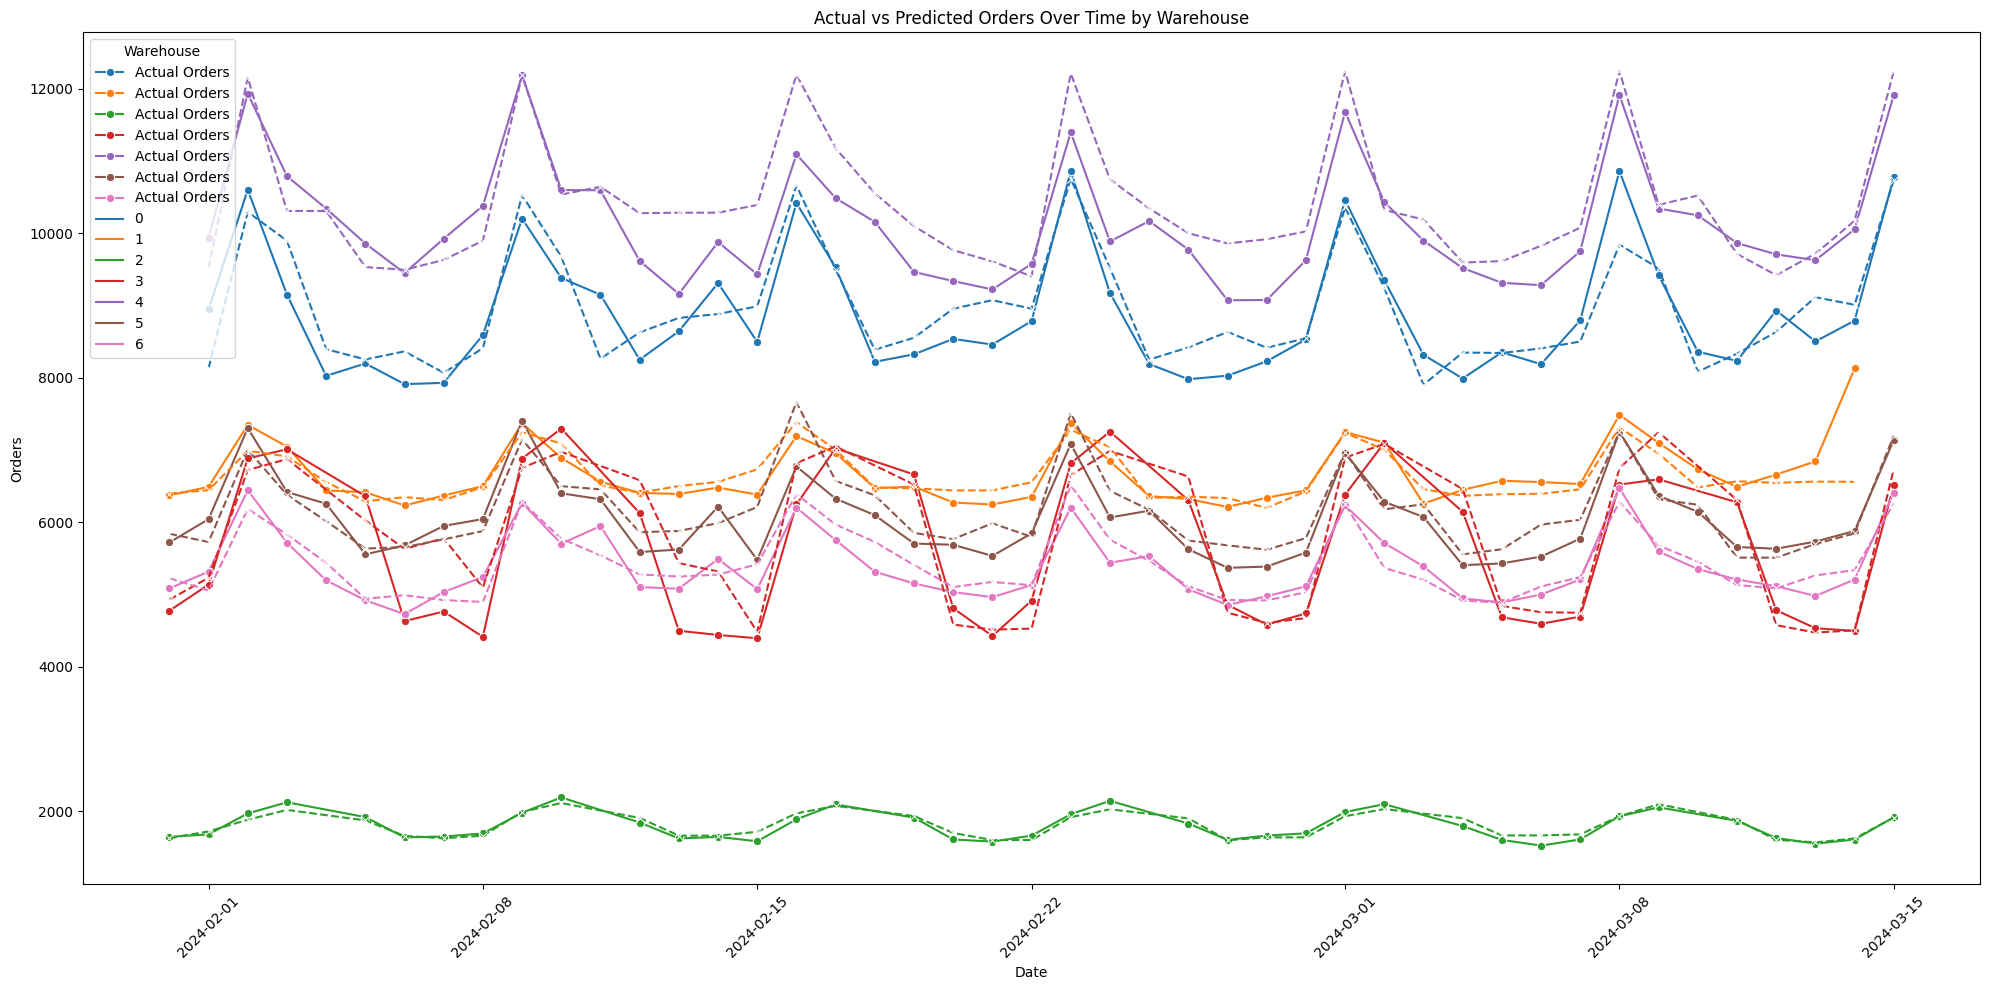

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the 'date' column to datetime if it's not already in datetime format
residual_df['date'] = pd.to_datetime(residual_df['date'])

# Create the plot with a specified color palette
plt.figure(figsize=(20, 10))

# Plot actual orders with the 'tab10' palette for high-contrast colors
sns.lineplot(
    data=residual_df, 
    x='date', 
    y='orders', 
    hue='warehouse', 
    marker='o', 
    palette='tab10',  # Use high-contrast tab10 palette
    label='Actual Orders'
)

# Plot predicted orders with the 'tab10' palette and a dashed line style
sns.lineplot(
    data=residual_df, 
    x='date', 
    y='predicted_orders', 
    hue='warehouse', 
    marker='x', 
    linestyle='--', 
    palette='tab10',  # Use the same palette for predicted orders
    legend=False  # Avoid duplicating the legend
)

# Add title and labels
plt.title('Actual vs Predicted Orders Over Time by Warehouse')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add legend
plt.legend(title='Warehouse')

# Show plot
plt.tight_layout()
plt.show()

In [37]:
X_train_final = pd.concat([X_train_base, X_test], axis=0)
pred_train = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train_final, train_df[col_y])
    pred_train[name] = model.predict(X_train_final)

# Meta model for stacking
meta_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
meta_model.fit(pred_train, train_df[col_y])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 12
[LightGBM] [Info] Start training from score 5535.443869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 3
[LightGBM] [Info] Start training from score 5535.443869


LGBMRegressor(random_state=42)

In [38]:
# Make predictions on test set and prepare submission file
pred_test = pd.DataFrame()

for name, model in models.items():
    pred_test[name] = model.predict(scoring_df.drop(columns=['date', 'id']))

final_pred_test = meta_model.predict(pred_test)

# Create submission file
df_result = pd.DataFrame({
    'id': test_id,
    'orders': final_pred_test
})

# Save the file
df_result.to_csv('df_result.csv', index=False)
df_result

,id,orders
0,Prague_1_2024-03-16,10790.072192
1,Prague_1_2024-03-17,10440.491468
2,Prague_1_2024-03-18,9914.664924
3,Prague_1_2024-03-19,9675.586220
4,Prague_1_2024-03-20,9675.586220
...,...,...
392,Budapest_1_2024-05-11,7078.469623
393,Budapest_1_2024-05-12,6664.856989
394,Budapest_1_2024-05-13,6771.441894
395,Budapest_1_2024-05-14,7029.861053
